# Feedback notebook

This notebook will analyse the answers to the feedback questions

In [1]:
from helper_functions import save_plot
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import seaborn as sns
import pandas as pd
import hashlib

## Configuration

In [2]:
translation_dict = {
    "Helt överens": "Strongly agree",
    "Överens": "Agree",
    "Varken eller": "Neither agree or disagree",
    "Inte överens": "Disagree",
    "Inte alls överens": "Strongly disagree",
    "Väldigt korrekt": "Very accurate",
    "Ganska korrekt": "Somewhat accurate",
    "Varken korrekt eller inkorrekt": "Neither accurate nor inaccurate",
    "Ganska inkorrekt": "Somewhat inaccurate",
    "Väldigt inkorrekt": "Very inaccurate",
    "Väldigt snabb": "Very quick",
    "Snabb": "Quick",
    "Måttlig": "Moderate",
    "Långsam": "Slow",
    "Väldigt långsam": "Very slow"
}

In [3]:
def make_sha_of_question(q: str) -> str:
    sha = hashlib.sha256(q.encode()).hexdigest()[:6]
    return sha

## Load the data from the database

In [4]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [5]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5223 non-null   int64         
 1   created_at        5223 non-nu

## Number of chats per day (cummulative)

Saved plot to feedback-01-frequency-of-answer-for-question-2e09fd


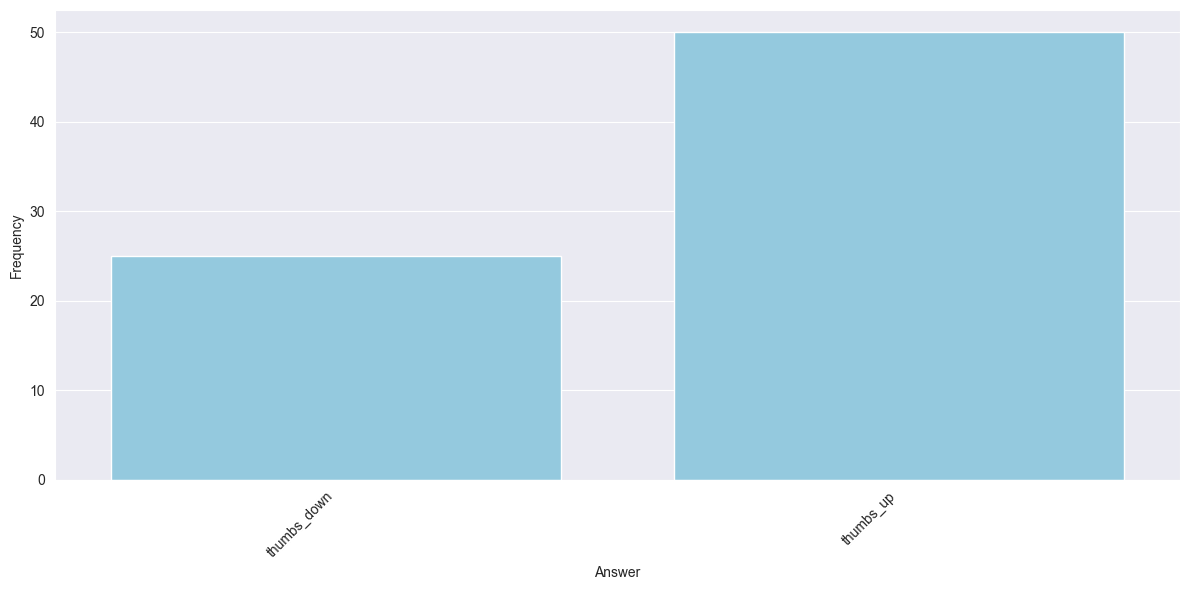

Saved plot to feedback-01-frequency-of-answer-for-question-cbfea1


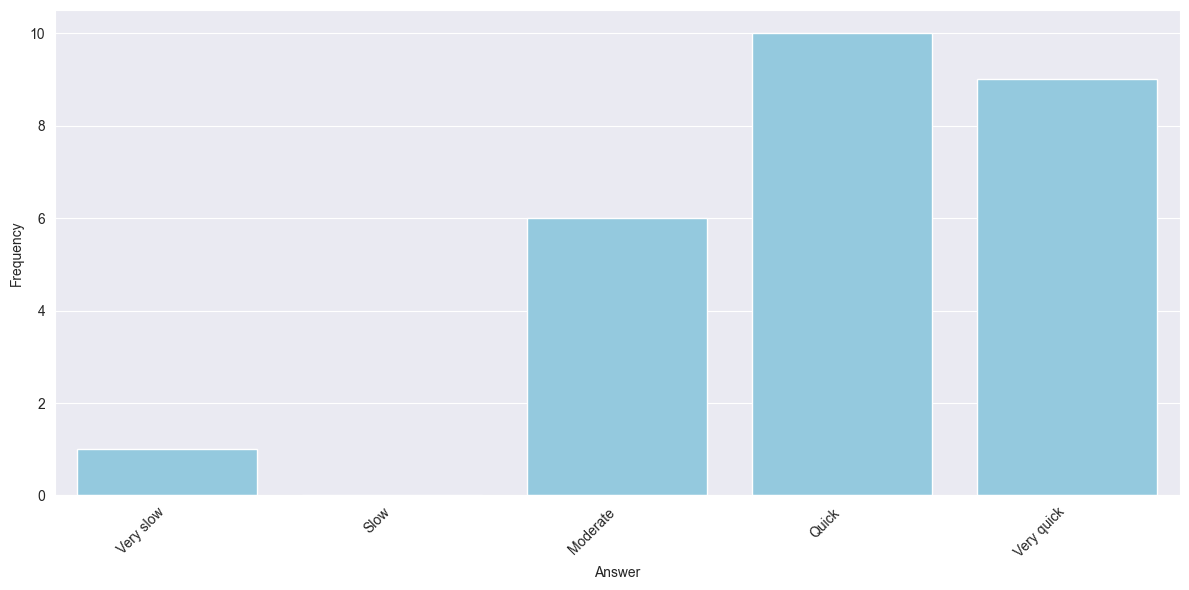

Saved plot to feedback-01-frequency-of-answer-for-question-ead094


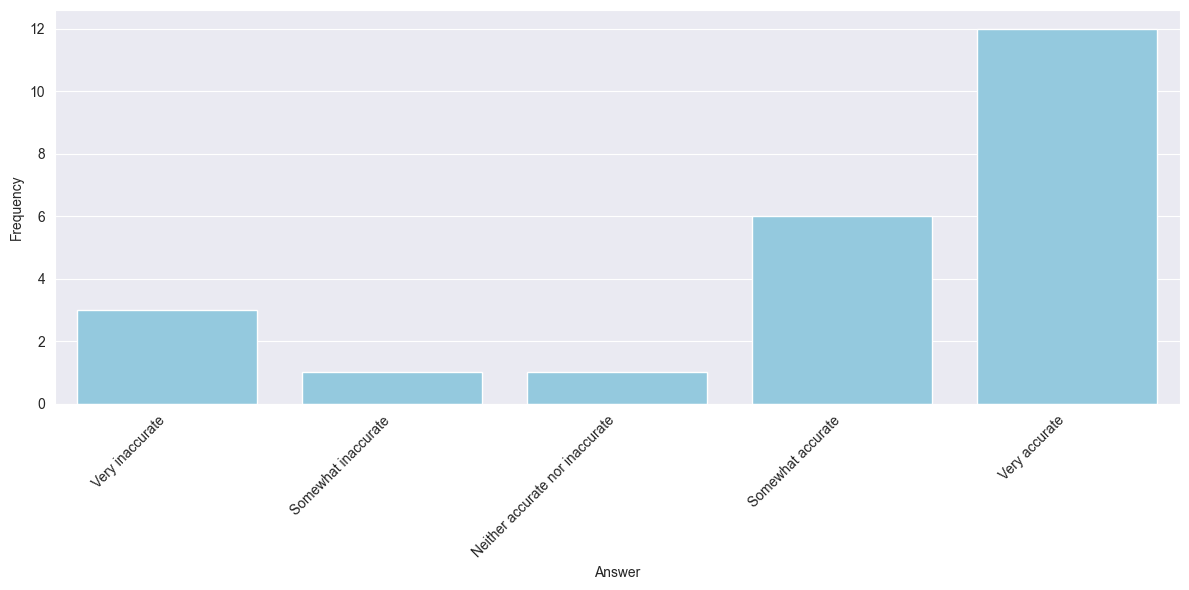

Saved plot to feedback-01-frequency-of-answer-for-question-d474ac


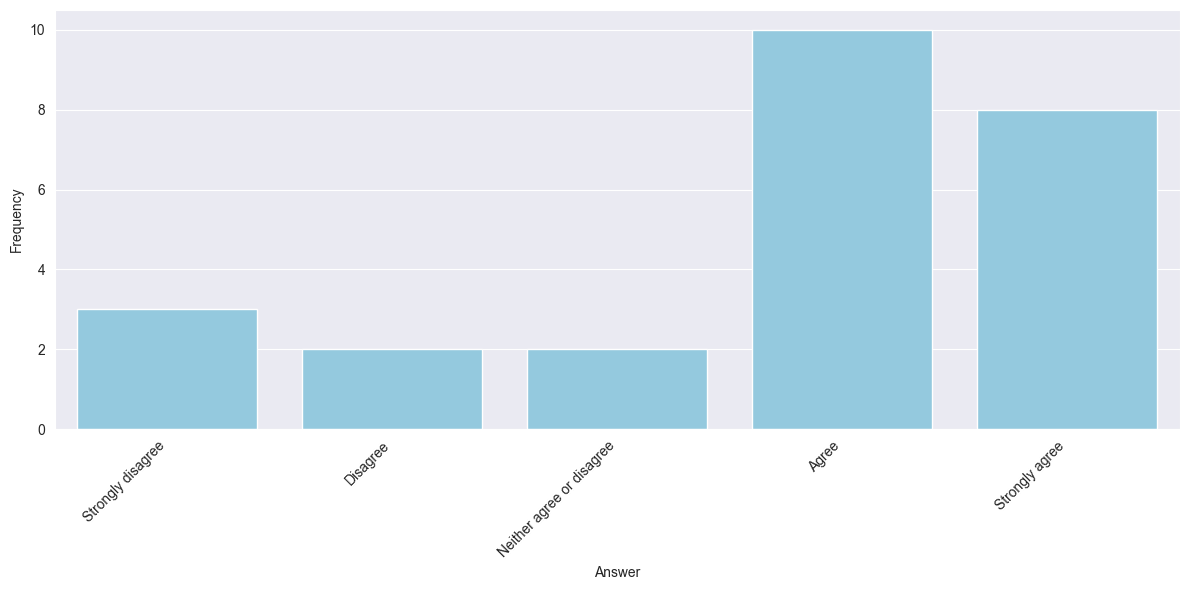

In [7]:
df_feedback_questions = dataframes['feedback_questions']
df_feedback = dataframes['feedback']
df_chats = dataframes['chats']
df_messages = dataframes['messages']

df_feedback['created_at'] = pd.to_datetime(df_feedback['created_at'])

df_merged_feedback = pd.merge(df_feedback, df_feedback_questions, left_on='feedback_question_id', right_on='id', how='left', suffixes=('', '_question'))

df_merged_feedback = df_merged_feedback[['id', 'feedback_question_id', 'answer', 'question_en', 'message_id']]
df_merged_feedback = df_merged_feedback[~df_merged_feedback['answer'].isin(['UNANSWERED'])]

df_merged_feedback = pd.merge(df_merged_feedback, df_messages[['id', 'chat_id']], left_on='message_id', right_on='id', how='left', suffixes=('', '_messages'))
df_merged_feedback = pd.merge(df_merged_feedback, df_chats[['id', 'llm_model_name']], left_on='chat_id', right_on='id', how='left', suffixes=('', '_chat'))

df_merged_feedback = df_merged_feedback.dropna(subset=['llm_model_name'])

questions = df_merged_feedback['question_en'].unique()
models = df_merged_feedback['llm_model_name'].unique()

df_merged_feedback['answer'] = df_merged_feedback['answer'].replace(translation_dict)

for question in questions:
    question_id = df_merged_feedback[df_merged_feedback['question_en'] == question]['feedback_question_id'].iloc[0]

    choices_data = df_feedback_questions[df_feedback_questions['id'] == question_id]['extra_data_en'].iloc[0]
    choices = choices_data["choices"]
    question_data = df_merged_feedback[df_merged_feedback['question_en'] == question]

    answer_frequency = question_data.groupby('answer').size().reindex(choices, fill_value=0).reset_index(name='count')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='answer', y='count', data=answer_frequency, color='skyblue')
    plt.xlabel('Answer')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.gca().invert_xaxis()
    save_plot(plt, f"feedback-01-frequency-of-answer-for-question-{make_sha_of_question(question)}", f"The number of answers to each answer for the question \\textit{{\"{question}\"}}", f"fig:feedback_01_frequency_of_answer_for_question_{make_sha_of_question(question)}")
    plt.show()

## Filter per model

Saved plot to feedback-02-frequency-of-answer-for-question-per-model-2e09fd


<Figure size 1200x600 with 0 Axes>

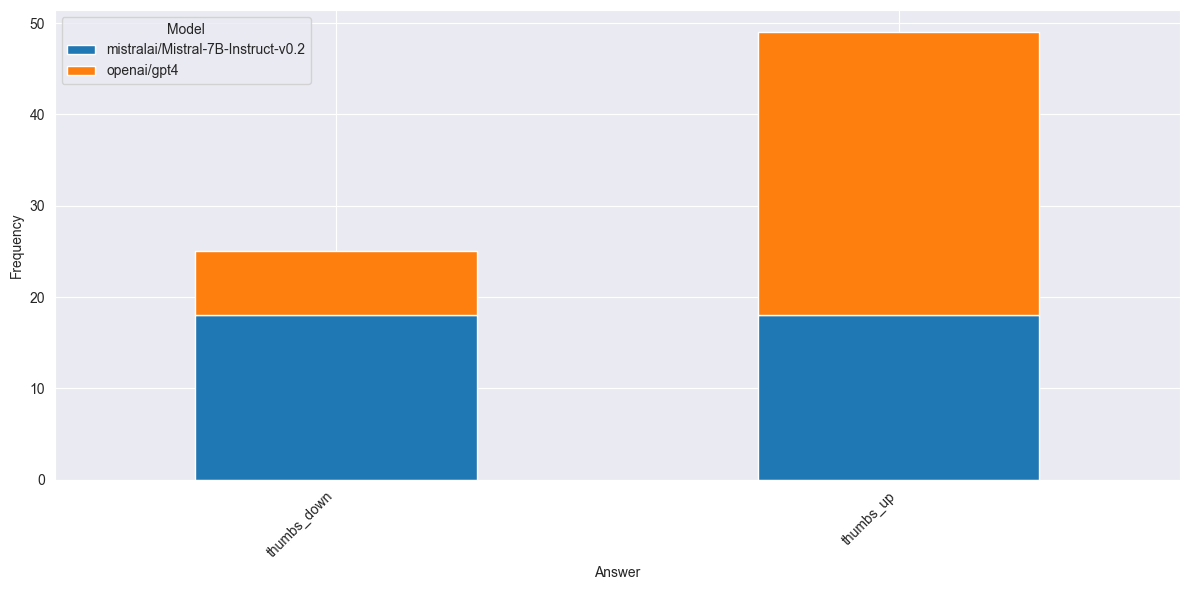

Saved plot to feedback-02-frequency-of-answer-for-question-per-model-cbfea1


<Figure size 1200x600 with 0 Axes>

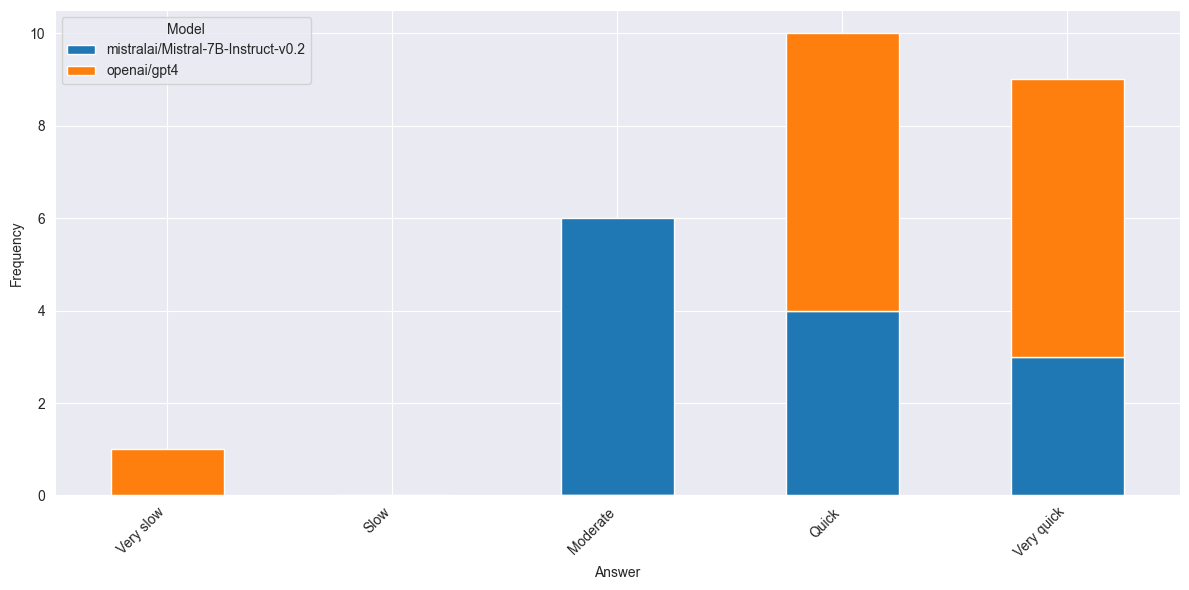

Saved plot to feedback-02-frequency-of-answer-for-question-per-model-ead094


<Figure size 1200x600 with 0 Axes>

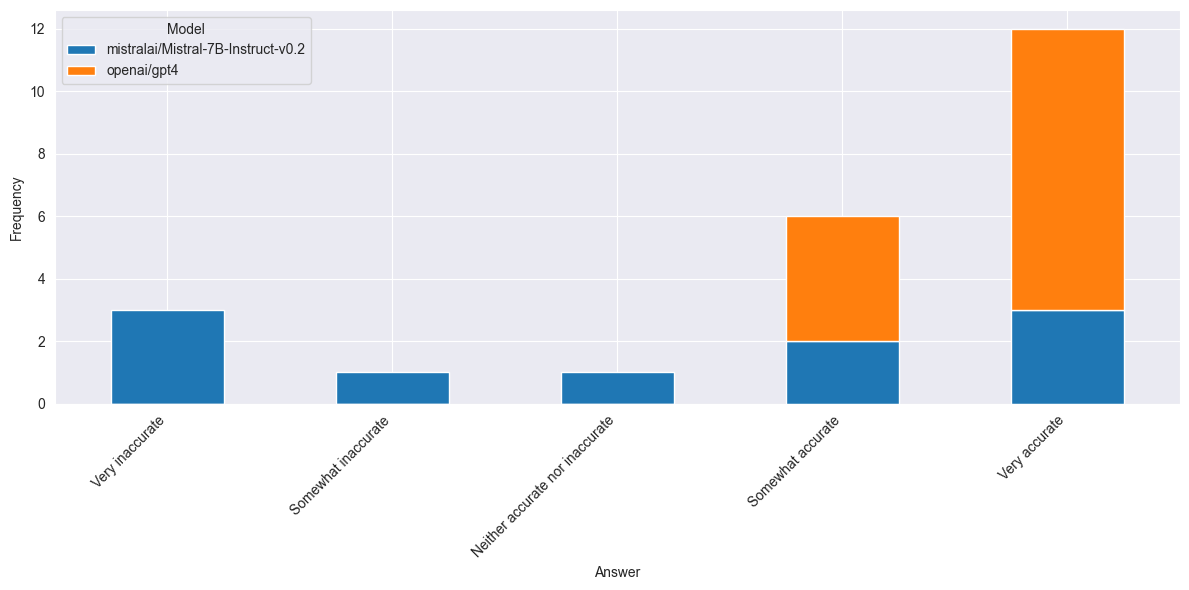

Saved plot to feedback-02-frequency-of-answer-for-question-per-model-d474ac


<Figure size 1200x600 with 0 Axes>

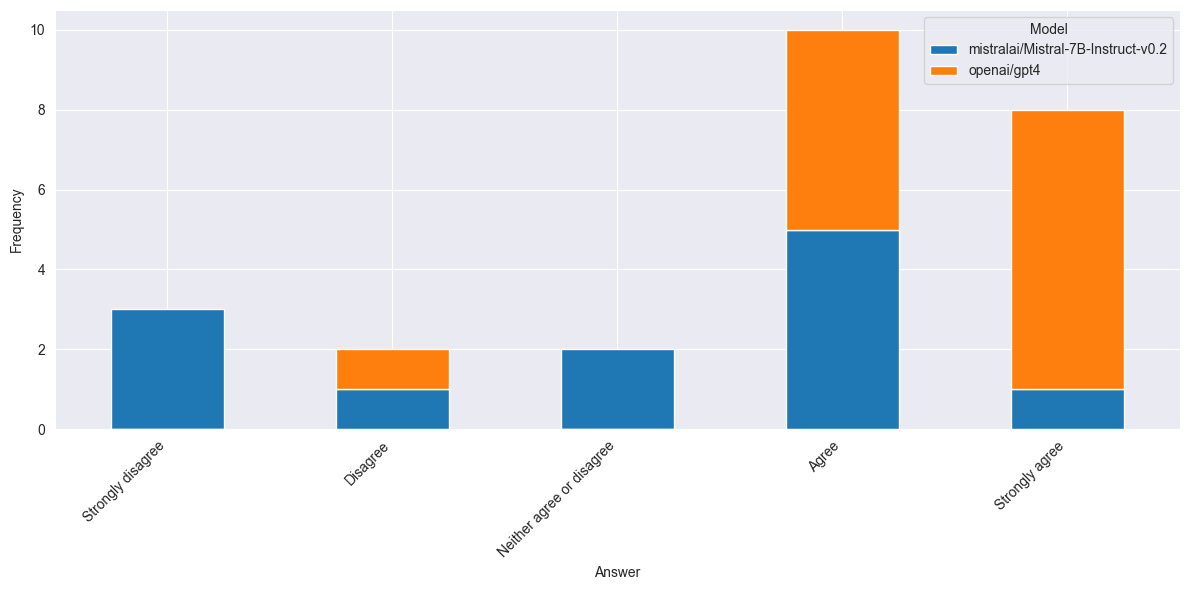

In [8]:
df_feedback_questions = dataframes['feedback_questions']
df_feedback = dataframes['feedback']
df_chats = dataframes['chats']
df_messages = dataframes['messages']

df_feedback['created_at'] = pd.to_datetime(df_feedback['created_at'])

df_merged_feedback = pd.merge(df_feedback, df_feedback_questions, left_on='feedback_question_id', right_on='id', how='left', suffixes=('', '_question'))

df_merged_feedback = df_merged_feedback[['id', 'feedback_question_id', 'answer', 'question_en', 'message_id']]
df_merged_feedback = df_merged_feedback[~df_merged_feedback['answer'].isin(['UNANSWERED'])]

df_merged_feedback = pd.merge(df_merged_feedback, df_messages[['id', 'chat_id']], left_on='message_id', right_on='id', how='left', suffixes=('', '_messages'))
df_merged_feedback = pd.merge(df_merged_feedback, df_chats[['id', 'llm_model_name']], left_on='chat_id', right_on='id', how='left', suffixes=('', '_chat'))

df_merged_feedback = df_merged_feedback.dropna(subset=['llm_model_name'])

questions = df_merged_feedback['question_en'].unique()
models = df_merged_feedback['llm_model_name'].unique()

df_merged_feedback['answer'] = df_merged_feedback['answer'].replace(translation_dict)

for question in questions:
    plt.figure(figsize=(12, 6))

    combined_data = []

    for model in models:
        if model == 'meta-llama/Meta-Llama-3-8B-Instruct':
            continue
        
        model_data = df_merged_feedback[df_merged_feedback['llm_model_name'] == model]
        question_id = None
        try:
            question_id = model_data[model_data['question_en'] == question]['feedback_question_id'].iloc[0]
        except IndexError:
            print(f'No answers to question {question} for model {model}')
            continue

        choices_data = df_feedback_questions[df_feedback_questions['id'] == question_id]['extra_data_en'].iloc[0]
        choices = choices_data["choices"]
        question_data = model_data[model_data['question_en'] == question]

        answer_frequency = question_data.groupby('answer').size().reindex(choices, fill_value=0).reset_index(name='count')
        answer_frequency['model'] = model
        combined_data.append(answer_frequency)

    combined_df = pd.concat(combined_data).pivot(index='answer', columns='model', values='count').fillna(0)
    combined_df = combined_df.reindex(choices)  # Ensure correct sorting of answers

    combined_df.plot(kind='bar', stacked=True, figsize=(12, 6))

    plt.xlabel('Answer')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.gca().invert_xaxis()
    save_plot(plt, f"feedback-02-frequency-of-answer-for-question-per-model-{make_sha_of_question(question)}", f"The number of answers to each answer for the question \\textit{{\"{question}\"}}", f"fig:feedback_02_frequency_of_answer_for_question_per_model_{make_sha_of_question(question)}")
    plt.show()